# Chat Intents

## Clustering without dimensionality reduction

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import random
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [5]:
X = data_sample['cleaned_text']
X.head()

0              im worried card might lost mail long usually take arrive
1                                         got charged fee shouldnt cash
2           charge making withdrawal took money account earlier charged
3    issue account dont see cheque deposit made yesterday please assist
4                                                 way people send money
Name: cleaned_text, dtype: object

### K-means with TF-IDF

In [6]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_transformed_vector = tfidf_vectorizer.fit_transform(X)
tfidf_transformed_vector.shape

(1000, 809)

In [7]:
k = 10
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans.fit(tfidf_transformed_vector)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [8]:
len(kmeans.labels_)

1000

In [9]:
def plot_kmeans(embeddings, k_range):
    sse = []
    silhouette_avg_n_clusters = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
        kmeans.fit(embeddings)
        sse.append(kmeans.inertia_)

        silhouette_avg = silhouette_score(embeddings, kmeans.predict(embeddings))
        silhouette_avg_n_clusters.append(silhouette_avg)


    # plot sse
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(k_range, sse)
    axes[0].set(xlabel = 'k clusters', ylabel = 'SSE', title = 'Elbow plot')
    axes[0].grid()
    
    # plot avg silhouette score
    axes[1].plot(k_range, silhouette_avg_n_clusters)
    axes[1].set(xlabel = 'k clusters', ylabel = 'Silhouette score', title = 'Silhouette score')
    axes[1].grid()

    plt.show()

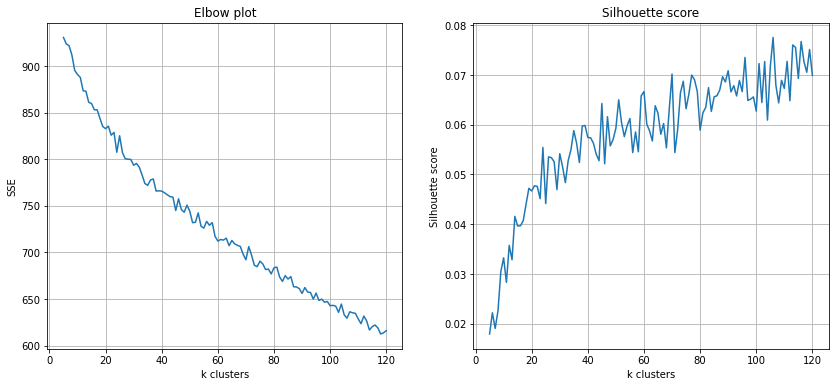

CPU times: user 42.1 s, sys: 1.14 s, total: 43.2 s
Wall time: 13.3 s


In [10]:
%%time

k_range = range(5, 121)

plot_kmeans(tfidf_transformed_vector, k_range)

### Sentence Embeddings

Start with Universal Sentence Encoder (USE) as an example sentence embedding model.

In [11]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)

print(f"module {module_url} loaded")

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [12]:
def embed_use(model, sentences):
    return model(sentences)

In [20]:
use_embeddings = embed_use(model_use, X)
use_embeddings.shape

TensorShape([1000, 512])

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer

In [25]:
model_st = SentenceTransformer('all-mpnet-base-v2')
st_embeddings = model_st.encode(X)
st_embeddings.shape

(1000, 768)

#### Sentence Embeddings + Kmeans

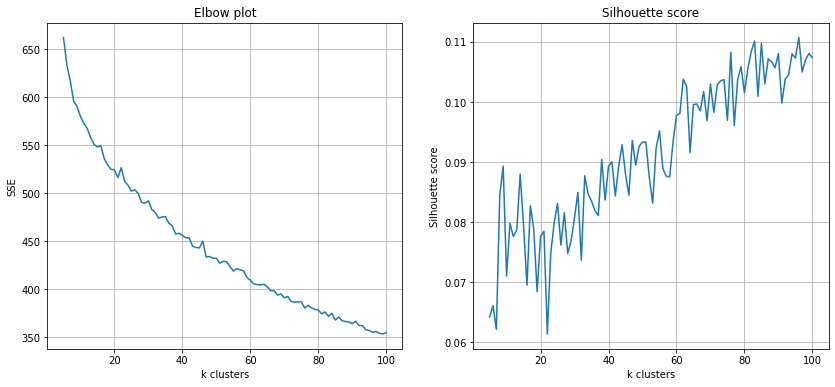

CPU times: user 1min 6s, sys: 3.38 s, total: 1min 9s
Wall time: 23.8 s


In [15]:
%%time

k_range = range(5, 101)

plot_kmeans(st_embeddings, k_range)

#### Sentence Embeddings + DBSCAN with 

In [17]:
db = DBSCAN(eps=0.25, min_samples=5, metric='cosine').fit(st_embeddings)
labels = db.labels_
len(np.unique(labels))

36

In [18]:
silhouette_score(st_embeddings, labels, metric='cosine')

-0.07814484

In [19]:
def plot_dbscan_eps(embeddings, eps_range, min_samples_range):
    silhouette_avg_n_clusters = {}

    for min_samples in min_samples_range:
        silhouette_avg_n_clusters[min_samples] = []
        for eps in eps_range:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine').fit(embeddings)
            labels = db.labels_

            if len(np.unique(labels)) > 1:
                silhouette_avg = silhouette_score(embeddings, labels, metric='cosine')
            else:
                silhouette_av = -1
            silhouette_avg_n_clusters[min_samples].append(silhouette_avg)

    
    # plot avg silhouette score
    fig, ax = plt.subplots(figsize=(8,5))
    for key, value in silhouette_avg_n_clusters.items():
        ax.plot(eps_range, silhouette_avg_n_clusters[key], label = key)
    
    ax.set(xlabel = 'epsilon', ylabel = 'Silhouette score', title = 'Silhouette score')
    ax.grid()
    plt.legend()
    plt.show()

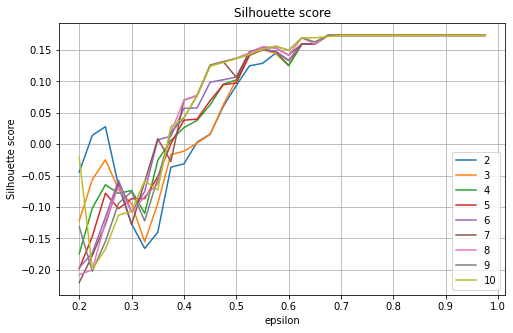

In [20]:
eps_range = np.arange(0.2, 1, 0.025)
min_samples_range = range(2, 11)
plot_dbscan_eps(st_embeddings, eps_range, min_samples_range)

In [21]:
db = DBSCAN(eps=0.6, min_samples=5, metric='cosine').fit(st_embeddings)
labels = db.labels_
len(np.unique(labels))

2

In [22]:
silhouette_score(st_embeddings, labels, metric='cosine')

0.1330917

### Hierarchical clustering

In [26]:
# Normalize the embeddings to unit length
st_embeddings_norm = st_embeddings /  np.linalg.norm(st_embeddings, axis=1, keepdims=True)

In [27]:
# Perform clustering
agglom_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5)
agglom_model.fit(st_embeddings_norm)
cluster_assignment = agglom_model.labels_

len(np.unique(cluster_assignment))

109

### HDBSCAN

In [28]:
clusters_hdbscan = hdbscan.HDBSCAN(min_cluster_size=2, 
                                   metric='euclidean', 
                                   cluster_selection_method='eom').fit(st_embeddings)

labels = clusters_hdbscan.labels_
len(np.unique(labels))

222

In [29]:
pd.Series(labels).value_counts().head(10)

-1      337
 188     11
 156      8
 149      8
 139      8
 94       7
 200      7
 183      7
 111      7
 171      6
dtype: int64

In [30]:
def random_search(embeddings, space, num_evals):
    
    results = []
    
    for i in range(num_evals):
        min_cluster_size = random.choice(space['min_cluster_size'])
        min_samples = random.choice(space['min_samples'])
        
        clusters_hdbscan = (hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                           min_samples = min_samples,
                                           metric='euclidean', 
                                           cluster_selection_method='eom') 
                                           .fit(embeddings))
    
        labels = clusters_hdbscan.labels_
        label_count = len(np.unique(labels))
        
        total_num = len(clusters_hdbscan.labels_)
        cost = (np.count_nonzero(clusters_hdbscan.probabilities_ < 0.05)/total_num) 
                
        results.append([i, min_cluster_size, min_samples, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'min_cluster_size', 'min_samples', 
                                               'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [31]:
%%time

space = {
    "min_cluster_size": range(2, 30),
    "min_samples": range(2, 30)
}

random_search(st_embeddings, space, num_evals=100).head(20)

CPU times: user 2min 6s, sys: 756 ms, total: 2min 7s
Wall time: 2min 11s


,run_id,min_cluster_size,min_samples,label_count,cost
53,53,2,11,3,0.043
91,91,2,8,3,0.055
2,2,14,4,3,0.171
19,19,12,6,3,0.191
73,73,2,14,3,0.231
1,1,4,11,3,0.306
72,72,9,8,4,0.326
98,98,6,12,3,0.342
60,60,5,12,3,0.342
61,61,27,3,3,0.361
